# Qiskit Optimization: Quantum algorithms for applications of optimization

EQTC 2021, Workshop 1.3, Nov. 30.

Atsushi Matsuo, Takashi Imamichi, IBM Research Quantum, IBM Research - Tokyo

Presenter: Atsushi Matsuo

## Hands-on of Qiskit optimization

Goal: Implement a Maxcut problem and solve it with Qiskit optimization

### Outline

- Overview of Qiskit Optimization and Qiskit Terra
- Workflow to define and solve an optimization model
- Example: Maxcut
- Exercise: TSP or other optimization problems

## Prerequisite

You need to install Qiskit in your PC or use [IBM Quantum Lab](https://quantum-computing.ibm.com/)
If you want to install Qiskit in your PC, see [Getting started page](https://qiskit.org/documentation/getting_started.html).

Make sure you have Qiskit in your environment as follows. You need 'qiskit-terra', 'qiskit-aer', 'qiskit-optimization' for this hands-on.

In [1]:
import qiskit
qiskit.__qiskit_version__

{'qiskit-terra': '0.19.1', 'qiskit-aer': '0.10.0', 'qiskit-ignis': None, 'qiskit-ibmq-provider': '0.18.2', 'qiskit-aqua': None, 'qiskit': None, 'qiskit-nature': '0.2.2', 'qiskit-finance': None, 'qiskit-optimization': '0.2.3', 'qiskit-machine-learning': None}

## Introduction to Qiskit

When using Qiskit a user workflow nominally consists of following four high-level steps:

- Build: Design a quantum circuit(s) that represents the problem you are considering.
- Compile: Compile circuits for a specific quantum service, e.g. a quantum system or classical simulator.
- Run: Run the compiled circuits on the specified quantum service(s). These services can be cloud-based or local.
- Analyze: Compute summary statistics and visualize the results of the experiments.

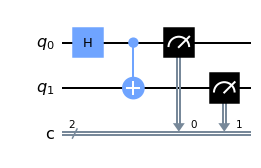

In [2]:
from qiskit import QuantumCircuit, transpile, Aer
from qiskit.visualization import plot_histogram

# Use Aer's qasm_simulator
simulator = Aer.get_backend('aer_simulator')

# Create a Quantum Circuit acting on the q register
circuit = QuantumCircuit(2, 2)

# Add a H gate on qubit 0
circuit.h(0)

# Add a CX (CNOT) gate on control qubit 0 and target qubit 1
circuit.cx(0, 1)

# Map the quantum measurement to the classical bits
circuit.measure([0,1], [0,1])

# compile the circuit down to low-level QASM instructions
# supported by the backend (not needed for simple circuits)
compiled_circuit = transpile(circuit, simulator)

# Draw the circuit
compiled_circuit.draw(output='mpl')


Total count for 00 and 11 are: {'11': 500, '00': 500}


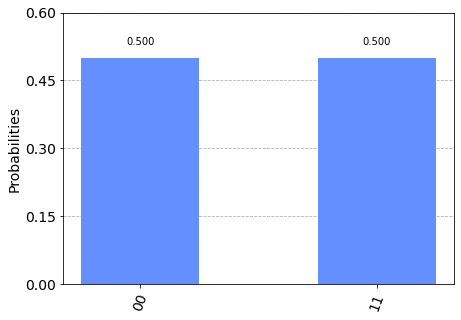

In [3]:
# Execute the circuit on the qasm simulator
job = simulator.run(compiled_circuit, shots=1000)

# Grab results from the job
result = job.result()

# Returns counts
counts = result.get_counts(compiled_circuit)
print("\nTotal count for 00 and 11 are:",counts)

plot_histogram(counts)

The circuit is to make the Bell state.
$$
|Bell\rangle = \frac{1}{\sqrt{2}}(|00\rangle + |11\rangle)
$$

In [4]:
# the bitstring starts from right to left
# the left bit corresponds to qubit 1 and the right corresponds to qubit 0

circuit = QuantumCircuit(2, 2)
circuit.x(0)
circuit.measure([0,1], [0,1])
job = simulator.run(circuit, shots=1000) # you can omit transpile if you run it on a simulator
print(job.result().get_counts())

{'01': 1000}


## Qiskit optimization

Qiskit optimization is part of Qiskit family. Qiskit optimization converts optimization problems into quantum circuits and interprets the results of circuit executions (usually bitstrings) into the variables of the original problem.

- Covers the whole range of solving optimization problems
- High-level modeling of optimization problems
- Automatic conversion of problems to required representations (Ising Hamiltonian)
- Allows users to solve problems using a large set of algorithms
  - QAOA, Grover adaptive Search, Classical solvers

## Workflow of Qiskit optimization

1. Modeling an optimization problem
  - Store it as `QuadraticProgram` object
2. Convert your problem into QUBO (Quadratic Unconstrained Binary Optimization)
3. Convert QUBO into an Ising Hamiltonian
4. Find the minimum eigen value and state of the Hamiltonian
5. Interpret the eigen state into the variables of the original problem

## Optimization problems
- Many practical problems in several fields are optimization problems.
- Optimization problems lie at the core of complex decision-making and definition of strategies.
- Searching for an optimal solution in a finite or countably infinite set of potential solutions.
- Optimality is defined with respect to some criterion function (called objective function), which is to be minimized or maximized.

## Typical objective functions
- Minimization: cost, distance, length of a traversal, weight, processing time, material, energy consumption, number of objects
  - E.g. Find the shortest path from A to B
- Maximization: profit, value, output, return, yield, utility, efficiency, capacity, number of objects
  - E.g. Production Planning

## Quadratic programs
- Qiskit Optimization supports Quadratically Constrained Quadratic Programs
  - Binary, integer, and continuous variables
  - Equality and inequality constraints
$$
\begin{aligned}
\text{minimize}\quad& x^\top Q_0 x + c^\top x\\
\text{subject to}\quad& A x \leq b\\
& x^\top Q_i x + a_i^\top x \leq r_i, \quad 1,\dots,i,\dots,q\\
& l_i \leq x_i \leq u_i, \quad 1,\dots,i,\dots,n,
\end{aligned}
$$
    where $Q_i$ are $n \times n$ matrices, $A$ is a $m \times n$ matrix , $x$, and $c$ are $n$-dimensional vectors

- Simple example of quadratic program
$$
\begin{aligned}
\text{maximize}\quad& 2xy+x+y+z\\
\text{subject to}\quad& x+y+z \leq 2\\
& x,y,z \in \{0,1\} \\
\end{aligned}
$$
  

- Covers various types of problems
  - Traveling salesman problem (TSP), Max cut, Vertex cover, Knapsack problem, and so on.
- Qiskit introduces the `QuadraticProgram` class to make a model of an optimization model.

## Modeling optimization problems
- Directly constructing a `QuadraticProgram`
- Loading a `QuadraticProgram` from a classical optimization solvers (Docplex and Gurobipy)
- Loading a `Quadratic Program` from an LP file

In [5]:
from qiskit_optimization import QuadraticProgram
# Define QuadraticProgram
qp = QuadraticProgram()
# Add variables
qp.binary_var('x')
qp.binary_var('y')
qp.integer_var(lowerbound=0, upperbound=7, name='z')
# Add an objective function 
qp.maximize(linear={'x': 2, 'y': 1, 'z': 1})
# Add a constraint
qp.linear_constraint({'x': 1, 'y': 1, 'z': 1}, '<=', 2, name='xyz_leq')
print(qp.export_as_lp_string())

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: CPLEX

Maximize
 obj: 2 x + y + z
Subject To
 xyz_leq: x + y + z <= 2

Bounds
 0 <= x <= 1
 0 <= y <= 1
       z <= 7

Binaries
 x y

Generals
 z
End



### Optional: Introduction of Docplex

Docplex is a modeling library for CPLEX. It has advanced modeling features such as indicator constraints and logical expressions. It would be more convinent if you want to make a complicate optimization model.
See https://ibmdecisionoptimization.github.io/docplex-doc/mp/index.html for details.

In [6]:
from docplex.mp.model import Model
model = Model()
x = model.binary_var('x')
y = model.binary_var('y')
z = model.integer_var(lb=0, ub=7, name='z')
model.maximize(2 * x + y + z)
model.add(x + y + z <= 2)
model.prettyprint()

// This file has been generated by DOcplex
// model name is: docplex_model1
// single vars section
dvar bool x;
dvar bool y;
dvar int z;

maximize
 2 x + y + z;
 
subject to {
 x + y + z <= 2;

}


In [7]:
# import Docplex model to QuadraticProgram
from qiskit_optimization.translators import from_docplex_mp
qp = from_docplex_mp(model)
print(qp.export_as_lp_string())

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: docplex_model1

Maximize
 obj: 2 x + y + z
Subject To
 c0: x + y + z <= 2

Bounds
 0 <= x <= 1
 0 <= y <= 1
       z <= 7

Binaries
 x y

Generals
 z
End



## Converting `QuadraticProgram` to an Ising Hamiltonian
- `QuadraticProgram` class is generic and powerful representation for optimization problems.
- However, quantum algorithms can not handle `QuadraticProgram`, directly.
  - Need to convert problems into Quadratic Unconstrained Binary Optimization (QUBO) problems, and eventually Ising Hamiltonians.
    - Converting flow: Original problem → QUBO → Ising Hamiltonian
  - QUBO: QuadraticProgram, but no constraints
  - Ising Hamiltonian: $H = \sum_i w_i Z_i + \sum_{i<j} w_{ij} Z_i Z_j$ where $Z_i$ is the pauli Z operator

  
- Qiskit offers a variety of converters, and automatically convert problems to Ising Hamiltonians.
  - Users do not need to bother with complicated conversion process.

### Inequality constraints to equality constraints

`InequalityToEqualityConverter` converts inequality constraints into equality constraints with additional slack variables to remove inequality constraints from `QuadraticProgram`. The upper bounds and the lower bounds of slack variables will be calculated from the difference between the left sides and the right sides of constraints. Signs of slack variables depend on symbols in constraints such as ≤ and ≥.

In [8]:
from qiskit_optimization.converters import InequalityToEquality
ineq2eq = InequalityToEquality()
qp_eq = ineq2eq.convert(qp)
print(qp_eq.export_as_lp_string())

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: docplex_model1

Maximize
 obj: 2 x + y + z
Subject To
 c0: x + y + z + c0@int_slack = 2

Bounds
 0 <= x <= 1
 0 <= y <= 1
       z <= 7
       c0@int_slack <= 2

Binaries
 x y

Generals
 z c0@int_slack
End



## Integer variable to binary variables

`IntegerToBinary` converts integer variables into binary variables and coefficients to remove integer variables from QuadraticProgram. For converting, bounded-coefficient encoding proposed in arxiv:1706.01945 (Eq. (5)) is used. For more detail of the encoding method, please see the paper.

We use the output of InequalityToEquality as starting point. Variable 𝑥 and 𝑦 are binary variables, while the variable 𝑧 and the slack variables 𝑥𝑦𝑧_𝑙𝑒𝑞@𝑖𝑛𝑡_𝑠𝑙𝑎𝑐𝑘 and 𝑥𝑦𝑧_𝑔𝑒𝑞@𝑖𝑛𝑡_𝑠𝑙𝑎𝑐𝑘 are integer variables. We print the problem again for reference.

In [9]:
from qiskit_optimization.converters import IntegerToBinary
int2bin = IntegerToBinary()
qp_eq_bin = int2bin.convert(qp_eq)
print(qp_eq_bin.export_as_lp_string())

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: docplex_model1

Maximize
 obj: 2 x + y + z@0 + 2 z@1 + 4 z@2
Subject To
 c0: x + y + z@0 + 2 z@1 + 4 z@2 + c0@int_slack@0 + c0@int_slack@1 = 2

Bounds
 0 <= x <= 1
 0 <= y <= 1
 0 <= z@0 <= 1
 0 <= z@1 <= 1
 0 <= z@2 <= 1
 0 <= c0@int_slack@0 <= 1
 0 <= c0@int_slack@1 <= 1

Binaries
 x y z@0 z@1 z@2 c0@int_slack@0 c0@int_slack@1
End



After converting, integer variables 𝑧 is replaced with three binary variables 𝑧@0, 𝑧@1 and 𝑧@2 with coefficients 1, 2 and 4, respectively as the above. The slack variables 𝑥𝑦𝑧_𝑙𝑒𝑞@𝑖𝑛𝑡_𝑠𝑙𝑎𝑐𝑘 and 𝑥𝑦𝑧_𝑔𝑒𝑞@𝑖𝑛𝑡_𝑠𝑙𝑎𝑐𝑘 that were introduced by InequalityToEquality are also both replaced with three binary variables with coefficients 1, 2, 2, and 1, 2, 3, respectively.

## Linear equality constraints to penalty

`LinearEqualityToPenalty` converts linear equality constraints into additional quadratic penalty terms of the objective function to map `QuadraticProgram` to an unconstrained form. An input to the converter has to be a QuadraticProgram with only linear equality constraints. Those equality constraints, e.g. $\sum_i a_i x_i = b$ where $a_i$ and $b$ are numbers and $x_i$ is a variable, will be added to the objective function in the form of $M(b -\sum_i a_i x_i)^2$ where $M$ is a large number as penalty factor. By default $M$ is automatically computed. The sign of the term depends on whether the problem type is a maximization or minimization.

In [10]:
from qiskit_optimization.converters import LinearEqualityToPenalty
lineq2penalty = LinearEqualityToPenalty()
qubo = lineq2penalty.convert(qp_eq_bin)
print(qubo.export_as_lp_string())

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: docplex_model1

Maximize
 obj: 46 x + 45 y + 45 z@0 + 90 z@1 + 180 z@2 + 44 c0@int_slack@0
      + 44 c0@int_slack@1 + [ - 22 x^2 - 44 x*y - 44 x*z@0 - 88 x*z@1
      - 176 x*z@2 - 44 x*c0@int_slack@0 - 44 x*c0@int_slack@1 - 22 y^2
      - 44 y*z@0 - 88 y*z@1 - 176 y*z@2 - 44 y*c0@int_slack@0
      - 44 y*c0@int_slack@1 - 22 z@0^2 - 88 z@0*z@1 - 176 z@0*z@2
      - 44 z@0*c0@int_slack@0 - 44 z@0*c0@int_slack@1 - 88 z@1^2 - 352 z@1*z@2
      - 88 z@1*c0@int_slack@0 - 88 z@1*c0@int_slack@1 - 352 z@2^2
      - 176 z@2*c0@int_slack@0 - 176 z@2*c0@int_slack@1 - 22 c0@int_slack@0^2
      - 44 c0@int_slack@0*c0@int_slack@1 - 22 c0@int_slack@1^2 ]/2 -44
Subject To

Bounds
 0 <= x <= 1
 0 <= y <= 1
 0 <= z@0 <= 1
 0 <= z@1 <= 1
 0 <= z@2 <= 1
 0 <= c0@int_slack@0 <= 1
 0 <= c0@int_slack@1 <= 1

Binaries
 x y z@0 z@1 z@2 c0@int_slack@0 c0@int_slack@1
End



## Maximization to minimization

`MaximizeToMinimize` flips both the sense (maximize to minimize) and the sign of the objective function. 

In [11]:
from qiskit_optimization.converters import MaximizeToMinimize
max2min = MaximizeToMinimize()
qubo_min = max2min.convert(qubo)
print(qubo_min.export_as_lp_string())

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: docplex_model1

Minimize
 obj: - 46 x - 45 y - 45 z@0 - 90 z@1 - 180 z@2 - 44 c0@int_slack@0
      - 44 c0@int_slack@1 + [ 22 x^2 + 44 x*y + 44 x*z@0 + 88 x*z@1 + 176 x*z@2
      + 44 x*c0@int_slack@0 + 44 x*c0@int_slack@1 + 22 y^2 + 44 y*z@0 + 88 y*z@1
      + 176 y*z@2 + 44 y*c0@int_slack@0 + 44 y*c0@int_slack@1 + 22 z@0^2
      + 88 z@0*z@1 + 176 z@0*z@2 + 44 z@0*c0@int_slack@0 + 44 z@0*c0@int_slack@1
      + 88 z@1^2 + 352 z@1*z@2 + 88 z@1*c0@int_slack@0 + 88 z@1*c0@int_slack@1
      + 352 z@2^2 + 176 z@2*c0@int_slack@0 + 176 z@2*c0@int_slack@1
      + 22 c0@int_slack@0^2 + 44 c0@int_slack@0*c0@int_slack@1
      + 22 c0@int_slack@1^2 ]/2 + 44
Subject To

Bounds
 0 <= x <= 1
 0 <= y <= 1
 0 <= z@0 <= 1
 0 <= z@1 <= 1
 0 <= z@2 <= 1
 0 <= c0@int_slack@0 <= 1
 0 <= c0@int_slack@1 <= 1

Binaries
 x y z@0 z@1 z@2 c0@int_slack@0 c0@int_slack@1
End



## All-in-one converter from QuadraticProgram to QUBO

`QuadraticProgramToQubo` is a special type of converter that applys all converters introduced above at once.
It is useful unless you need to customize the conversion flow.

In [12]:
from qiskit_optimization.converters import QuadraticProgramToQubo
qp2qubo = QuadraticProgramToQubo()
qubo = qp2qubo.convert(qp)
print(qubo.export_as_lp_string())

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: docplex_model1

Minimize
 obj: - 46 x - 45 y - 45 z@0 - 90 z@1 - 180 z@2 - 44 c0@int_slack@0
      - 44 c0@int_slack@1 + [ 22 x^2 + 44 x*y + 44 x*z@0 + 88 x*z@1 + 176 x*z@2
      + 44 x*c0@int_slack@0 + 44 x*c0@int_slack@1 + 22 y^2 + 44 y*z@0 + 88 y*z@1
      + 176 y*z@2 + 44 y*c0@int_slack@0 + 44 y*c0@int_slack@1 + 22 z@0^2
      + 88 z@0*z@1 + 176 z@0*z@2 + 44 z@0*c0@int_slack@0 + 44 z@0*c0@int_slack@1
      + 88 z@1^2 + 352 z@1*z@2 + 88 z@1*c0@int_slack@0 + 88 z@1*c0@int_slack@1
      + 352 z@2^2 + 176 z@2*c0@int_slack@0 + 176 z@2*c0@int_slack@1
      + 22 c0@int_slack@0^2 + 44 c0@int_slack@0*c0@int_slack@1
      + 22 c0@int_slack@1^2 ]/2 + 44
Subject To

Bounds
 0 <= x <= 1
 0 <= y <= 1
 0 <= z@0 <= 1
 0 <= z@1 <= 1
 0 <= z@2 <= 1
 0 <= c0@int_slack@0 <= 1
 0 <= c0@int_slack@1 <= 1

Binaries
 x y z@0 z@1 z@2 c0@int_slack@0 c0@int_slack@1
End



## Converting a QUBO to an Ising Hamiltonian

Finding the solution to a QUBO is equivalent to finding the ground state of a corresponding Ising Hamiltonian, which is an important problem not only in optimization, but also in quantum chemistry and physics. For this translation, the binary variables taking values in {0,1} are replaced by spin variables taking values in {−1,+1}, which allows to replace the resulting spin variables by Pauli Z matrices, and thus, an Ising Hamiltonian.

In [13]:
from qiskit_optimization.translators import to_ising
op, offset = to_ising(qubo)
print(offset)
print(op)

198.5
-38.5 * ZIIIIII
- 38.5 * IZIIIII
+ 5.5 * ZZIIIII
- 152.0 * IIZIIII
+ 22.0 * ZIZIIII
+ 22.0 * IZZIIII
- 76.0 * IIIZIII
+ 11.0 * ZIIZIII
+ 11.0 * IZIZIII
+ 44.0 * IIZZIII
- 38.0 * IIIIZII
+ 5.5 * ZIIIZII
+ 5.5 * IZIIZII
+ 22.0 * IIZIZII
+ 11.0 * IIIZZII
- 38.0 * IIIIIZI
+ 5.5 * ZIIIIZI
+ 5.5 * IZIIIZI
+ 22.0 * IIZIIZI
+ 11.0 * IIIZIZI
+ 5.5 * IIIIZZI
- 37.5 * IIIIIIZ
+ 5.5 * ZIIIIIZ
+ 5.5 * IZIIIIZ
+ 22.0 * IIZIIIZ
+ 11.0 * IIIZIIZ
+ 5.5 * IIIIZIZ
+ 5.5 * IIIIIZZ


You can compute the minimum eigen state and eigen value of the Hamiltonian with Qiskit terra's algorithms as follows.

In [14]:
from qiskit.algorithms.minimum_eigen_solvers import NumPyMinimumEigensolver
solver = NumPyMinimumEigensolver()
result = solver.compute_minimum_eigenvalue(op)
print(result)

{   'aux_operator_eigenvalues': None,
    'eigenstate': VectorStateFn(Statevector([0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
             0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
             0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
             0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
             0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
             0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
             0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
             0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
             0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
             0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
             0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
             0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
             0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
             0.+0.j, 0.+0.j, 0.+0

But, you usually don't have to do it by yourself. Qiskit optimization takes care of it. I introduce `MinimumEigenOptimizer` as an example of algorithms. It takes `QuadraticProgram` as an input and computes the best solution (not necessarily optimal). It also interprets the results of quantum circuits (usually bit strings) into variables. The following example solves the problem with QAOA.

In [15]:
from qiskit_optimization.algorithms import MinimumEigenOptimizer

from qiskit import Aer
from qiskit.utils import QuantumInstance
from qiskit.algorithms import QAOA
from qiskit.algorithms.optimizers import COBYLA

qins = QuantumInstance(backend=Aer.get_backend('aer_simulator'), shots=1000)
meo = MinimumEigenOptimizer(QAOA(optimizer=COBYLA(maxiter=100), reps=1, quantum_instance=qins))
result = meo.solve(qp)
print(result)
print(f'\nnumber of solution samples: {len(result.samples)}')
print('display the best 5 solution samples')
for sample in result.samples[:5]:
    print(sample)

optimal function value: 3.0
optimal value: [1. 1. 0.]
status: SUCCESS

number of solution samples: 32
display the best 5 solution samples
SolutionSample(x=array([1., 1., 0.]), fval=3.0, probability=0.218, status=<OptimizationResultStatus.SUCCESS: 0>)
SolutionSample(x=array([1., 0., 1.]), fval=3.0, probability=0.0009999999999999998, status=<OptimizationResultStatus.SUCCESS: 0>)
SolutionSample(x=array([0., 1., 1.]), fval=2.0, probability=0.0009999999999999998, status=<OptimizationResultStatus.SUCCESS: 0>)
SolutionSample(x=array([0., 0., 2.]), fval=2.0, probability=0.036000000000000004, status=<OptimizationResultStatus.SUCCESS: 0>)
SolutionSample(x=array([1., 0., 0.]), fval=2.0, probability=0.01, status=<OptimizationResultStatus.SUCCESS: 0>)


You can visualize the circuits executed.

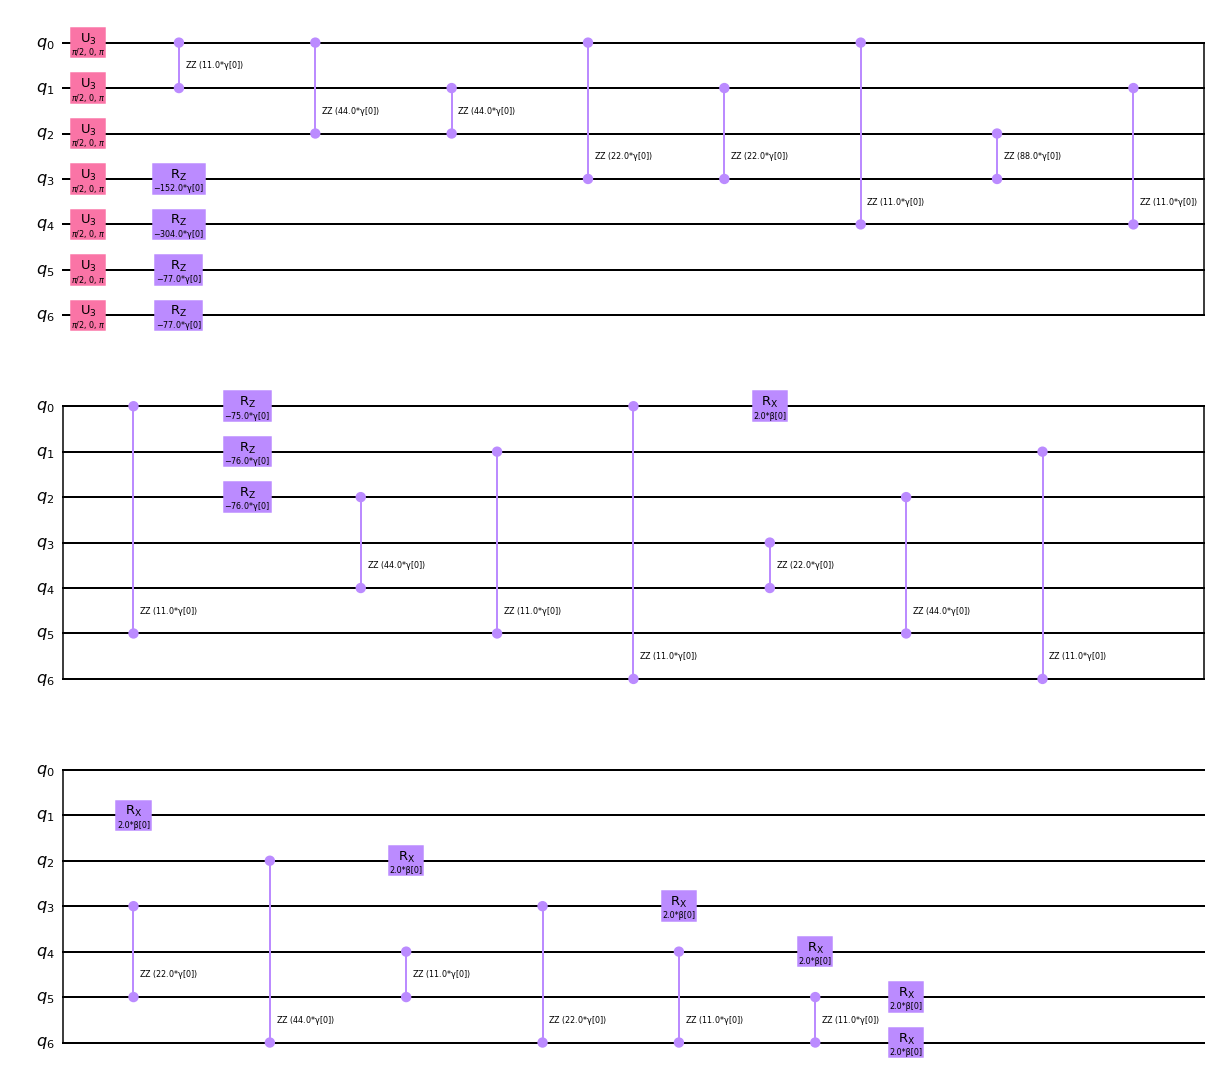

In [16]:
meo.min_eigen_solver.ansatz.decompose().decompose().draw('mpl')

You can use VQE as a solver of minimum eigen state and eigen value

In [17]:
from qiskit.algorithms import VQE
from qiskit.circuit.library import RealAmplitudes

meo = MinimumEigenOptimizer(VQE(ansatz=RealAmplitudes(reps=2, entanglement='linear'), optimizer=COBYLA(maxiter=100), quantum_instance=qins))
result = meo.solve(qp)
print(result)
print(f'\nnumber of solution samples: {len(result.samples)}')
print('display the best 5 solution samples')
for sample in result.samples[:5]:
    print(sample)

optimal function value: 3.0
optimal value: [1. 0. 1.]
status: SUCCESS

number of solution samples: 11
display the best 5 solution samples
SolutionSample(x=array([1., 0., 1.]), fval=3.0, probability=0.016, status=<OptimizationResultStatus.SUCCESS: 0>)
SolutionSample(x=array([1., 0., 0.]), fval=2.0, probability=0.002999999999999999, status=<OptimizationResultStatus.SUCCESS: 0>)
SolutionSample(x=array([0., 0., 2.]), fval=2.0, probability=0.06, status=<OptimizationResultStatus.SUCCESS: 0>)
SolutionSample(x=array([0., 1., 0.]), fval=1.0, probability=0.032, status=<OptimizationResultStatus.SUCCESS: 0>)
SolutionSample(x=array([0., 0., 1.]), fval=1.0, probability=0.7200000000000001, status=<OptimizationResultStatus.SUCCESS: 0>)


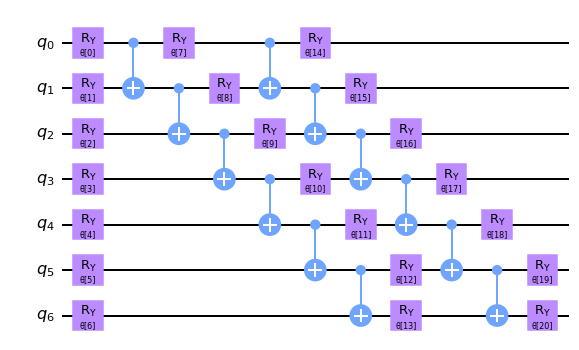

In [18]:
meo.min_eigen_solver.ansatz.decompose().draw('mpl')

### Optional
You can also solve the problem with classical solvers such as CPLEX and Gurobi.
The following example works if you installed CPLEX.
Note that if you want to solve your problem with CPLEX, you have to use Python 3.7 or 3.8 and install cplex as follows and restart this note.
```
%pip install cplex
```

In [19]:
# if you install cplex, the following should work.
try:
    import cplex
    print(cplex.Environment().get_version())
except:
    print('cplex is not installed')

20.1.0.0


In [20]:
from qiskit_optimization.algorithms import CplexOptimizer
try:
    optimizer = CplexOptimizer()
    result = optimizer.solve(qp)
    print(result)
    print(f'\nnumber of solution samples: {len(result.samples)}')
    print('display solution samples')
    for sample in result.samples:
        print(sample)
except:
    print('cplex is not installed')

optimal function value: 3.0
optimal value: [1. 1. 0.]
status: SUCCESS

number of solution samples: 1
display solution samples
SolutionSample(x=[1.0, 1.0, 0], fval=3.0, probability=1.0, status=<OptimizationResultStatus.SUCCESS: 0>)


## Application Example: Maxcut

Overview of maxcut
- NP-complete problem, known as classically intractable problem
- Applications in clustering, network science, statical physics, and so on. 
- Formal definition of the problem is as follows:
  - Consider $n$-node undirected graph $G=(V, E)$ where $|V|=n$ with edge weights $w_{ij} > 0, w_{ij}=w_{ji}, \text{for } (i,j) \in E$
  - Cut is defined as a partition of the original set $V$ into two subsets.
  - Objective function to be optimized is the sum of weights of edges connecting nodes in the two different subsets, *crossing* the cut. 
  $$ \text{maximize} \sum_{(i,j) \in E} [w_{ij} x_i (1-x_j) + w_{ji} x_j (1-x_i)]$$
  - No constraints

## What do we want to do?
- Divide nodes into two subsets
- Maximize the number of edges connecting nodes in the two different subsets

Ref: https://en.wikipedia.org/wiki/Maximum_cut

Qiskit optimization has a collection of predefined problems called "applications". Maxcut is included as part of "applications".
The following example uses `Maxcut` application class.

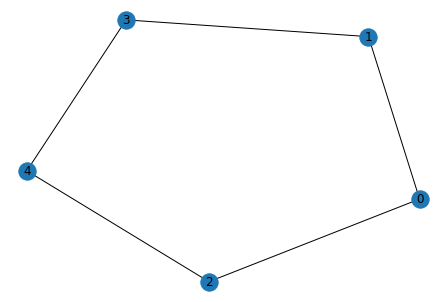

In [21]:
import networkx as nx
# Make a graph with degree=2 and #node=5
graph = nx.random_regular_graph(d=2, n=5, seed=111)
pos = nx.spring_layout(graph, seed=111)
# Application class for a Max-cut problem
# Make a Max-cut problem from the graph
from qiskit_optimization.applications import Maxcut
maxcut = Maxcut(graph)
maxcut.draw(pos=pos)

In [22]:
# Make a QuadraticProgram by calling to_quadratic_program()
qp = maxcut.to_quadratic_program()
print(qp)

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: Max-cut

Maximize
 obj: 2 x_0 + 2 x_1 + 2 x_2 + 2 x_3 + 2 x_4 + [ - 4 x_0*x_1 - 4 x_0*x_2
      - 4 x_1*x_3 - 4 x_2*x_4 - 4 x_3*x_4 ]/2
Subject To

Bounds
 0 <= x_0 <= 1
 0 <= x_1 <= 1
 0 <= x_2 <= 1
 0 <= x_3 <= 1
 0 <= x_4 <= 1

Binaries
 x_0 x_1 x_2 x_3 x_4
End



Solving it with QAOA

result:
 optimal function value: 4.0
optimal value: [0. 1. 1. 0. 0.]
status: SUCCESS

solution:
 [[0, 3, 4], [1, 2]]

time: 1.0769610404968262


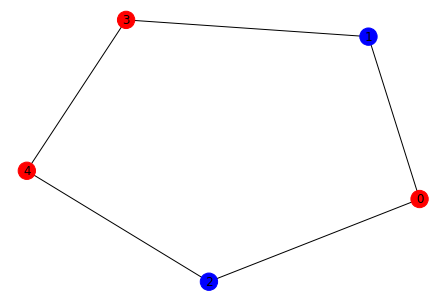

In [23]:
meo = MinimumEigenOptimizer(min_eigen_solver=QAOA(reps=1, quantum_instance=qins))
result = meo.solve(qp)
print('result:\n', result)
print('\nsolution:\n', maxcut.interpret(result))
print('\ntime:', result.min_eigen_solver_result.optimizer_time)
maxcut.draw(result, pos=pos)

Checking the solution with Numpy Eigensolver (classical optimizer)

result:
 optimal function value: 4.0
optimal value: [0. 1. 1. 1. 0.]
status: SUCCESS

solution:
 [[0, 4], [1, 2, 3]]


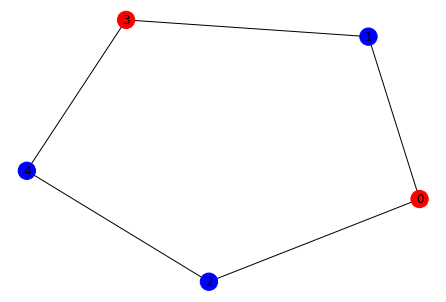

In [24]:
# Numpy Eigensolver
meo = MinimumEigenOptimizer(min_eigen_solver=NumPyMinimumEigensolver())
result = meo.solve(qp)
print('result:\n', result)
print('\nsolution:\n', maxcut.interpret(result))
maxcut.draw(result, pos=pos)

## More details of Maxcut
In this section, we look into solving Maxcut with Qiskit Optimization deeply.

In [25]:
import itertools
import networkx as nx
import numpy as np

import matplotlib.pyplot as plt 
#%matplotlib inline

import qiskit
from qiskit import QuantumCircuit, Aer, execute, transpile
from qiskit.circuit import ParameterVector
from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit.opflow import I, Z, PauliSumOp
from qiskit.algorithms import VQE, QAOA
from qiskit.algorithms.optimizers import COBYLA
from qiskit.circuit.library import TwoLocal

Make sure that you installed qiskit-terra, qiskit-aer, and qiskit-optimization.

In [26]:
print(qiskit.__qiskit_version__)

{'qiskit-terra': '0.19.1', 'qiskit-aer': '0.10.0', 'qiskit-ignis': None, 'qiskit-ibmq-provider': '0.18.2', 'qiskit-aqua': None, 'qiskit': None, 'qiskit-nature': '0.2.2', 'qiskit-finance': None, 'qiskit-optimization': '0.2.3', 'qiskit-machine-learning': None}


## Generate a graph and solve Maxcut naively

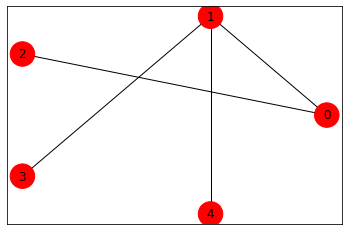

In [27]:
# Generating a graph with 5 nodes 
n = 5
V = np.arange(0,n,1)
E = [(0,1,1), (0,2,1), (1,3,1), (1,4,1)]

G = nx.Graph()
G.add_nodes_from(V)
G.add_weighted_edges_from(E)

# Generate plot of the Graph
colors       = ['r' for node in G.nodes()]
default_axes = plt.axes(frameon=True)
pos          = nx.circular_layout(G)

nx.draw_networkx(G, node_color=colors, node_size=600, alpha=1, ax=default_axes, pos=pos)

In [28]:
# Compute the value of the cost function
def cost_function(x,G):
    if isinstance(x, str):
        x = [int(e) for e in reversed(x)]  # notice that the endianess of qiskit (right to left)

    E = G.edges()
    if(len(x) != len(G.nodes())):
        return np.nan
        
    C = 0
    for index in E:
        e1 = index[0]
        e2 = index[1]
        
        w = G[e1][e2]['weight']
        C += w*x[e1]*(1-x[e2]) + w*(1-x[e1])*x[e2]

    return C

cost 2


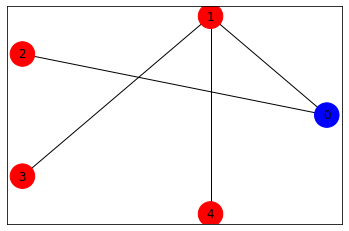

In [29]:
def draw_sol(G, x, pos=None):
    if isinstance(x, str):
        x = [int(e) for e in reversed(x)]  # notice that the endianess of qiskit (right to left)
    print('cost', cost_function(x, G))
    cmap = ['r', 'b']
    colors = [cmap[x[node]] for node in G.nodes()]
    default_axes = plt.axes(frameon=True)
    if pos is None:
        pos = nx.circular_layout(G)
    nx.draw_networkx(G, node_color=colors, node_size=600, alpha=1, ax=default_axes, pos=pos)

draw_sol(G, [1,0,0,0,0], pos)

In [30]:
def naive_opt(G):
    n = len(G.nodes())
    best = 0
    sol = []
    for x in itertools.product([0,1], repeat=n):
        val = cost_function(x, G)
        if best < val:
            best = val
            sol = [x]
        elif best == val:
            sol.append(x)
    return best, sol
best, x = naive_opt(G)
print(best, x)

4 [(0, 1, 1, 0, 0), (1, 0, 0, 1, 1)]


cost 4


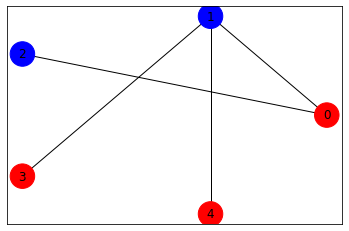

In [31]:
draw_sol(G, x[0], pos)

## Solve Maxcut with Qiskit Optimization

In [32]:
# Make an optimization problem with Docplex
# See http://ibmdecisionoptimization.github.io/docplex-doc/mp/index.html for details
from docplex.mp.model import Model

In [33]:
def model(G):
    mod = Model('maxcut')
    var = [mod.binary_var(name=f'x{i}') for i in range(len(G.nodes()))]
    mod.maximize(mod.sum(var[i] * (1-var[j]) + (1-var[i]) * var[j] for i, j in G.edges()))
    return mod
mod = model(G)
print(mod.export_as_lp_string())

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: maxcut

Maximize
 obj: 2 x0 + 3 x1 + x2 + x3 + x4 + [ - 4 x0*x1 - 4 x0*x2 - 4 x1*x3 - 4 x1*x4 ]/2
Subject To

Bounds
 0 <= x0 <= 1
 0 <= x1 <= 1
 0 <= x2 <= 1
 0 <= x3 <= 1
 0 <= x4 <= 1

Binaries
 x0 x1 x2 x3 x4
End



In [34]:
# Solve the model with CPLEX
# You need to install cplex as follows.
# %pip install cplex
# If you didn't install cplex, you can skip this cell.
try:
    print(mod.solve())
except:
    print('cplex is not installed')

solution for: maxcut
objective: 4
x0=1
x3=1
x4=1



In [35]:
from qiskit_optimization.problems import QuadraticProgram
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit_optimization.translators import from_docplex_mp, to_ising

In [36]:
# Convert the Docplex model into QuadraticProgram, then Hamiltonian.
qp = from_docplex_mp(mod)
H2, offset2 = to_ising(qp)
print('from qp')
print(H2)
print(offset2)

from qp
0.5 * ZIIZI
+ 0.5 * IZIZI
+ 0.5 * IIZIZ
+ 0.5 * IIIZZ
-2.0


optimal function value: 4.0
optimal value: [0. 1. 1. 0. 0.]
status: SUCCESS
cost 4.0, prob 0.04150, {'x0': 0, 'x1': 1, 'x2': 1, 'x3': 0, 'x4': 0}
cost 4.0, prob 0.03650, {'x0': 1, 'x1': 0, 'x2': 0, 'x3': 1, 'x4': 1}
cost 3.0, prob 0.00700, {'x0': 0, 'x1': 1, 'x2': 0, 'x3': 0, 'x4': 0}
cost 3.0, prob 0.04400, {'x0': 1, 'x1': 1, 'x2': 0, 'x3': 0, 'x4': 0}
cost 3.0, prob 0.05050, {'x0': 1, 'x1': 0, 'x2': 0, 'x3': 1, 'x4': 0}
cost 4


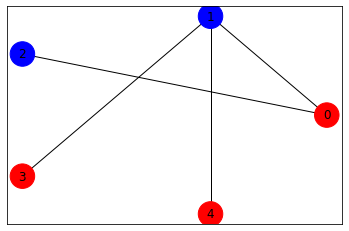

In [37]:
# Solve the problem with qiskit-optimization's MinimumEigenOptimizer
maxiter2 = 1000
seed = 1234

qp = from_docplex_mp(mod)
ins = QuantumInstance(backend=Aer.get_backend('aer_simulator'), shots=2000, seed_simulator=seed, seed_transpiler=seed)
qaoa = QAOA(optimizer=COBYLA(maxiter=maxiter2), quantum_instance=ins, reps=3)
min_eigen_optimizer = MinimumEigenOptimizer(qaoa)
result = min_eigen_optimizer.solve(qp)
print(result)
varnames = [v.name for v in result.variables]
for sample in result.samples[:5]:
    x = [int(x) for x in sample.x]
    print(f'cost {sample.fval}, prob {sample.probability:.5f}, {dict(zip(varnames, x))}')
draw_sol(G, [int(x) for x in result.x], pos)  # need to convert float to int

## Solve Maxcut with noise model

Since real devices have limitation of qubit connectivity (called coupling map), we need to transpile quantum circuits so that the resulting circuit can be executed on the device. Some SWAP gates are usually inserted.

In [38]:
# Use noise model
from qiskit import IBMQ
from qiskit.providers.aer.noise import NoiseModel
from qiskit.test.mock import FakeBelem

backend = FakeBelem()
noise_model = NoiseModel.from_backend(backend)
coupling_map = backend.configuration().coupling_map
print(coupling_map)
print(noise_model)

[[0, 1], [1, 0], [1, 2], [1, 3], [2, 1], [3, 1], [3, 4], [4, 3]]
NoiseModel:
  Basis gates: ['cx', 'id', 'reset', 'rz', 'sx', 'x']
  Instructions with noise: ['reset', 'measure', 'cx', 'id', 'sx', 'x']
  Qubits with noise: [0, 1, 2, 3, 4]
  Specific qubit errors: [('id', (0,)), ('id', (1,)), ('id', (2,)), ('id', (3,)), ('id', (4,)), ('sx', (0,)), ('sx', (1,)), ('sx', (2,)), ('sx', (3,)), ('sx', (4,)), ('x', (0,)), ('x', (1,)), ('x', (2,)), ('x', (3,)), ('x', (4,)), ('cx', (4, 3)), ('cx', (3, 4)), ('cx', (3, 1)), ('cx', (1, 3)), ('cx', (2, 1)), ('cx', (1, 2)), ('cx', (1, 0)), ('cx', (0, 1)), ('reset', (0,)), ('reset', (1,)), ('reset', (2,)), ('reset', (3,)), ('reset', (4,)), ('measure', (0,)), ('measure', (1,)), ('measure', (2,)), ('measure', (3,)), ('measure', (4,))]


optimal function value: 4.0
optimal value: [0. 1. 1. 0. 0.]
status: SUCCESS
cost 4.0, prob 0.01367, {'x0': 0, 'x1': 1, 'x2': 1, 'x3': 0, 'x4': 0}
cost 4.0, prob 0.02148, {'x0': 1, 'x1': 0, 'x2': 0, 'x3': 1, 'x4': 1}
cost 3.0, prob 0.12500, {'x0': 0, 'x1': 1, 'x2': 0, 'x3': 0, 'x4': 0}
cost 3.0, prob 0.05664, {'x0': 1, 'x1': 1, 'x2': 0, 'x3': 0, 'x4': 0}
cost 3.0, prob 0.01172, {'x0': 1, 'x1': 0, 'x2': 0, 'x3': 1, 'x4': 0}
cost 4


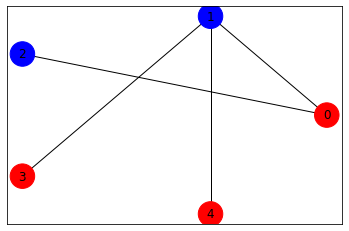

In [39]:
# QAOA with reps=5 and ibmq_belem noise simulator
algorithm_globals.random_seed = seed
ins_noise = QuantumInstance(backend=Aer.get_backend('aer_simulator'), seed_simulator=seed, seed_transpiler=seed, noise_model=noise_model, coupling_map=coupling_map, optimization_level=1)
qaoa = QAOA(optimizer=COBYLA(maxiter=maxiter2), quantum_instance=ins_noise, reps=5)
min_eigen_optimizer = MinimumEigenOptimizer(qaoa)
result = min_eigen_optimizer.solve(qp)
print(result)
varnames = [v.name for v in result.variables]
for sample in result.samples[:5]:
    x = [int(x) for x in sample.x]
    print(f'cost {sample.fval}, prob {sample.probability:.5f}, {dict(zip(varnames, x))}')
draw_sol(G, [int(x) for x in result.x], pos)  # need to convert float to int

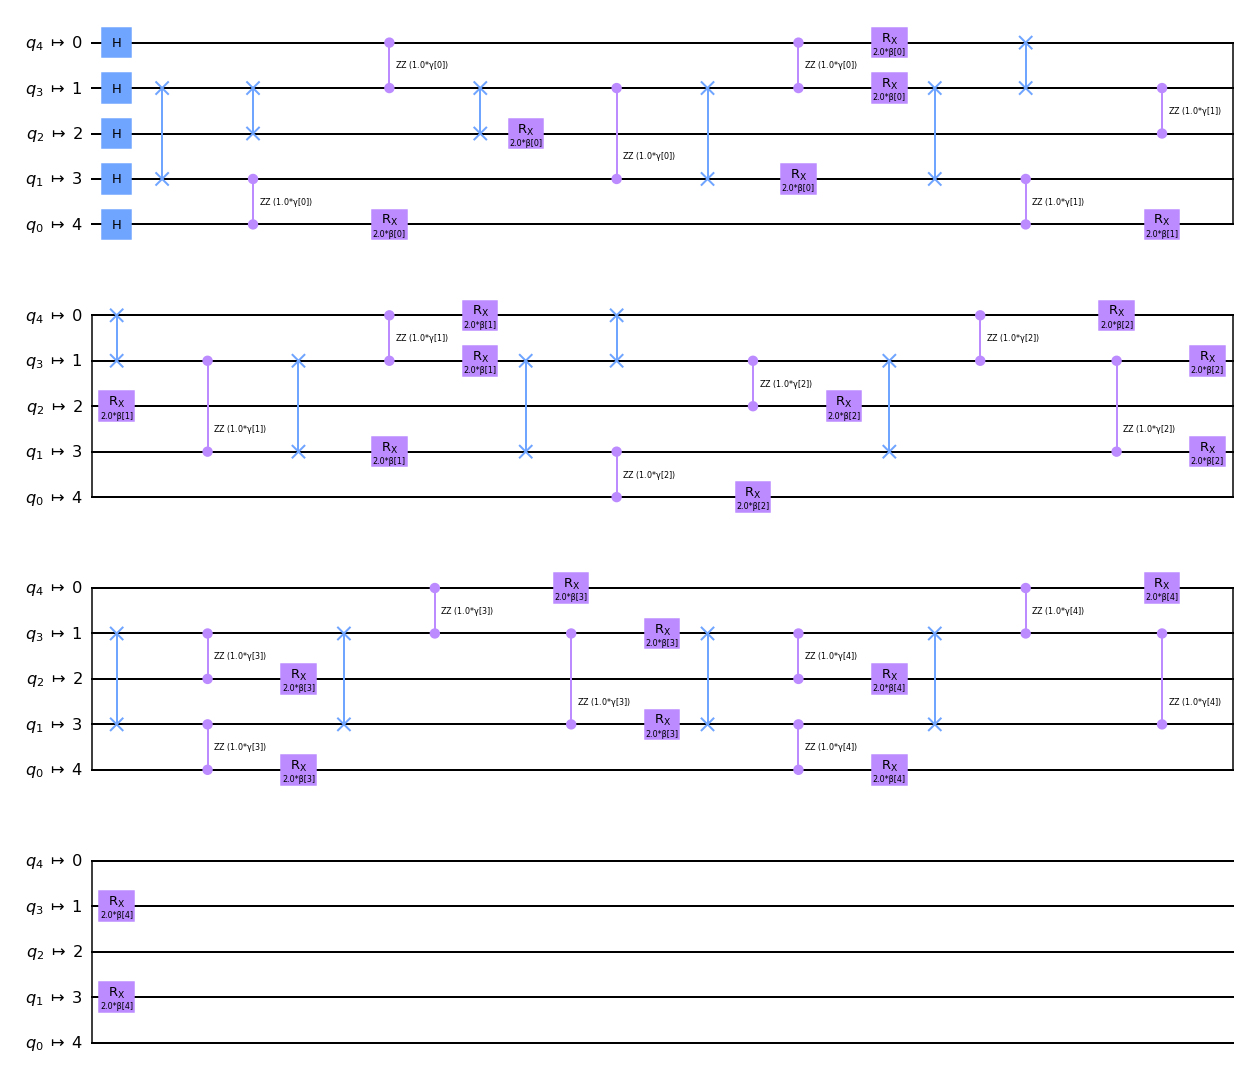

In [40]:
ins_noise.transpile(qaoa.ansatz)[0].draw(output='mpl')

In [41]:
# Custom noise model
# See https://qiskit.org/documentation/apidoc/aer_noise.html for details
import qiskit.providers.aer.noise as noise

# Error probabilities
prob_1 = 0.01  # 1-qubit gate
prob_2 = 0.1   # 2-qubit gate

# Depolarizing quantum errors
error_1 = noise.depolarizing_error(prob_1, 1)
error_2 = noise.depolarizing_error(prob_2, 2)

# Add errors to noise model
noise_model2 = noise.NoiseModel()
noise_model2.add_all_qubit_quantum_error(error_1, ['u1', 'u2', 'u3'])
noise_model2.add_all_qubit_quantum_error(error_2, ['cx'])

optimal function value: 4.0
optimal value: [0. 1. 1. 0. 0.]
status: SUCCESS
cost 4.0, prob 0.01660, {'x0': 0, 'x1': 1, 'x2': 1, 'x3': 0, 'x4': 0}
cost 4.0, prob 0.02637, {'x0': 1, 'x1': 0, 'x2': 0, 'x3': 1, 'x4': 1}
cost 3.0, prob 0.08984, {'x0': 0, 'x1': 1, 'x2': 0, 'x3': 0, 'x4': 0}
cost 3.0, prob 0.06836, {'x0': 1, 'x1': 1, 'x2': 0, 'x3': 0, 'x4': 0}
cost 3.0, prob 0.01953, {'x0': 1, 'x1': 0, 'x2': 0, 'x3': 1, 'x4': 0}
cost 4


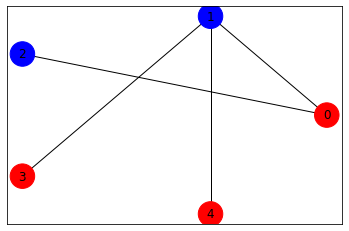

In [42]:
# QAOA with p=5 and custom noise simulator
algorithm_globals.random_seed = seed
ins_noise2 =  quantum_instance=QuantumInstance(backend=Aer.get_backend('aer_simulator'), seed_simulator=seed, noise_model=noise_model2)
qaoa = QAOA(optimizer=COBYLA(maxiter=maxiter2), quantum_instance=ins_noise2, reps=5)
min_eigen_optimizer = MinimumEigenOptimizer(qaoa)
result = min_eigen_optimizer.solve(qp)
print(result)
varnames = [v.name for v in result.variables]
for sample in result.samples[:5]:
    x = [int(x) for x in sample.x]
    print(f'cost {sample.fval}, prob {sample.probability:.5f}, {dict(zip(varnames, x))}')
draw_sol(G, [int(x) for x in result.x], pos)  # need to convert float to int

## Exercise: Traveling salesman problem (TSP)

The traveling salesman is a person that goes from city to city to sell merchandise. The objective in this case is to find the shortest path that would enable the salesman to visit all the cities and return to its hometown, i.e. the city where he started traveling. By doing this, the salesman gets to maximize potential sales in the least amount of time.

Find the shortest Hamiltonian cycle in a graph $G=(V,E)$ with $n=|V|$ nodes and distances, $w_{ij}$ (distance from vertex $i$ to vertex $j$). A Hamiltonian cycle is described by $N^2$ variables $x_{i,p}$, where $i$ represents the node and $p$ represents its order in a prospective cycle. The decision variable takes the value 1 if the solution occurs at node $i$ at time order $p$. We require that every node can only appear once in the cycle, and for each time a node has to occur. This amounts to the two constraints (here and in the following, whenever not specified, the summands run over 0,1,...n-1)

Here is an example of the formulation.
$$
\begin{align*}
\text{minimize}\quad&\sum_{(i,j)\in E}w_{ij}\sum_{p=0}^{n-1} x_{i,p}x_{j,(p+1) \text{ mod } n}\\
\text{subject to}\quad&\sum_{i=0}^{n-1} x_{i,p} = 1, \quad p = 0,\dots,n-1\\
&\sum_{p=0}^{n-1} x_{i,p} = 1, \quad i = 0,\dots,n-1\\
&x_{i,p} \in \{0, 1\}, i = 0,\dots,n-1, p = 0,\dots,n-1.
\end{align*}
$$

In [43]:
import matplotlib.pyplot as plt
import matplotlib.axes as axes
import numpy as np
import networkx as nx
from docplex.mp.model import Model

from qiskit import Aer
from qiskit.tools.visualization import plot_histogram
from qiskit.circuit.library import TwoLocal
from qiskit_optimization.applications import Maxcut, Tsp
from qiskit.algorithms import VQE, NumPyMinimumEigensolver, QAOA
from qiskit.algorithms.optimizers import COBYLA
from qiskit.utils import algorithm_globals, QuantumInstance
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit_optimization.problems import QuadraticProgram
from qiskit_optimization.translators import from_docplex_mp

In [44]:
def draw_graph(G, colors, pos):
    default_axes = plt.axes(frameon=True)
    nx.draw_networkx(G, node_color=colors, node_size=600, alpha=.8, ax=default_axes, pos=pos)
    edge_labels = nx.get_edge_attributes(G, 'weight')
    nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=edge_labels)

distance
 [[ 0. 48. 91.]
 [48.  0. 63.]
 [91. 63.  0.]]


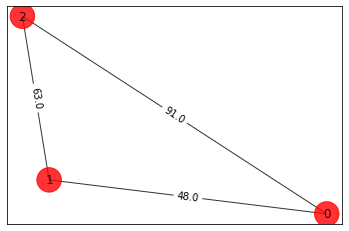

In [45]:
# Generating a graph of 3 nodes
n = 3
num_qubits = n ** 2
tsp = Tsp.create_random_instance(n, seed=123)
adj_matrix = nx.to_numpy_matrix(tsp.graph)
print('distance\n', adj_matrix)

colors = ['r' for node in tsp.graph.nodes]
pos = [tsp.graph.nodes[node]['pos']  for node in tsp.graph.nodes]
draw_graph(tsp.graph, colors, pos)

### Brute force approach

order = (0, 1, 2) Distance = 202.0
Best order from brute force = (0, 1, 2) with total distance = 202.0


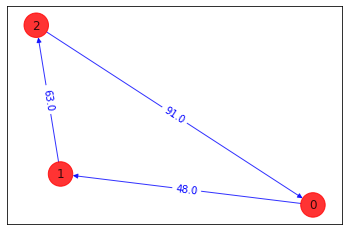

In [46]:
from itertools import permutations

def brute_force_tsp(w, N):
    a = list(permutations(range(1,N)))
    last_best_distance = 1e10
    for i in a:
        distance = 0
        pre_j = 0
        for j in i:
            distance = distance + w[j,pre_j]
            pre_j = j
        distance = distance + w[pre_j,0]
        order = (0,) + i
        if distance < last_best_distance:
            best_order = order
            last_best_distance = distance
            print('order = ' + str(order) + ' Distance = ' + str(distance))
    return last_best_distance, best_order

best_distance, best_order = brute_force_tsp(adj_matrix , n)
print('Best order from brute force = ' + str(best_order) + ' with total distance = ' + str(best_distance))

def draw_tsp_solution(G, order, colors, pos):
    G2 = nx.DiGraph()
    G2.add_nodes_from(G)
    n = len(order)
    for i in range(n):
        j = (i + 1) % n
        G2.add_edge(order[i], order[j], weight=G[order[i]][order[j]]['weight'])
    default_axes = plt.axes(frameon=True)
    nx.draw_networkx(G2, node_color=colors, edge_color='b', node_size=600, alpha=.8, ax=default_axes, pos=pos)
    edge_labels = nx.get_edge_attributes(G2, 'weight')
    nx.draw_networkx_edge_labels(G2, pos, font_color='b', edge_labels=edge_labels)

draw_tsp_solution(tsp.graph, best_order, colors, pos)

## Let's implement an optimization model of TSP and solve it with Qiskit optimization!

In [47]:
# n: number of nodes
# adj_matrix: distance matrix, adj_matrix[i, j] = distance between i and j


































### Solution

In [48]:
mdl = Model(name="TSP")
x = {(i, p): mdl.binary_var(name=f"x_{i},{p}") for i in range(n) for p in range(n)}
tsp_func = mdl.sum(
    adj_matrix[i, j] * x[i, p] * x[j, (p + 1) % n]
    for i in range(n)
    for j in range(n)
    for p in range(n)
    if i != j
)
mdl.minimize(tsp_func)
for i in range(n):
    mdl.add_constraint(mdl.sum(x[i, p] for p in range(n)) == 1)
for p in range(n):
    mdl.add_constraint(mdl.sum(x[i, p] for i in range(n)) == 1)
qp = from_docplex_mp(mdl)
print(qp.export_as_lp_string())

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: TSP

Minimize
 obj: [ 96 x_0,0*x_1,1 + 96 x_0,0*x_1,2 + 182 x_0,0*x_2,1 + 182 x_0,0*x_2,2
      + 96 x_0,1*x_1,0 + 96 x_0,1*x_1,2 + 182 x_0,1*x_2,0 + 182 x_0,1*x_2,2
      + 96 x_0,2*x_1,0 + 96 x_0,2*x_1,1 + 182 x_0,2*x_2,0 + 182 x_0,2*x_2,1
      + 126 x_1,0*x_2,1 + 126 x_1,0*x_2,2 + 126 x_1,1*x_2,0 + 126 x_1,1*x_2,2
      + 126 x_1,2*x_2,0 + 126 x_1,2*x_2,1 ]/2
Subject To
 c0: x_0,0 + x_0,1 + x_0,2 = 1
 c1: x_1,0 + x_1,1 + x_1,2 = 1
 c2: x_2,0 + x_2,1 + x_2,2 = 1
 c3: x_0,0 + x_1,0 + x_2,0 = 1
 c4: x_0,1 + x_1,1 + x_2,1 = 1
 c5: x_0,2 + x_1,2 + x_2,2 = 1

Bounds
 0 <= x_0,0 <= 1
 0 <= x_0,1 <= 1
 0 <= x_0,2 <= 1
 0 <= x_1,0 <= 1
 0 <= x_1,1 <= 1
 0 <= x_1,2 <= 1
 0 <= x_2,0 <= 1
 0 <= x_2,1 <= 1
 0 <= x_2,2 <= 1

Binaries
 x_0,0 x_0,1 x_0,2 x_1,0 x_1,1 x_1,2 x_2,0 x_2,1 x_2,2
End



In [52]:
maxiter = 200
ins = QuantumInstance(backend=Aer.get_backend('aer_simulator'), shots=200)
qaoa = QAOA(optimizer=COBYLA(maxiter=maxiter), quantum_instance=ins, reps=3)
min_eigen_optimizer = MinimumEigenOptimizer(qaoa)
result = min_eigen_optimizer.solve(qp)
print(result)
varnames = [v.name for v in result.variables]
for sample in result.samples[:5]:
    x = [int(x) for x in sample.x]
    print(f'cost {sample.fval}, prob {sample.probability:.5f}, {dict(zip(varnames, x))}')

optimal function value: 202.0
optimal value: [1. 0. 0. 0. 0. 1. 0. 1. 0.]
status: SUCCESS
cost 202.0, prob 0.00500, {'x_0,0': 1, 'x_0,1': 0, 'x_0,2': 0, 'x_1,0': 0, 'x_1,1': 0, 'x_1,2': 1, 'x_2,0': 0, 'x_2,1': 1, 'x_2,2': 0}
cost 202.0, prob 0.00500, {'x_0,0': 1, 'x_0,1': 0, 'x_0,2': 0, 'x_1,0': 0, 'x_1,1': 1, 'x_1,2': 0, 'x_2,0': 0, 'x_2,1': 0, 'x_2,2': 1}
cost 0.0, prob 0.00500, {'x_0,0': 1, 'x_0,1': 1, 'x_0,2': 0, 'x_1,0': 0, 'x_1,1': 0, 'x_1,2': 0, 'x_2,0': 0, 'x_2,1': 0, 'x_2,2': 0}
cost 0.0, prob 0.00500, {'x_0,0': 0, 'x_0,1': 1, 'x_0,2': 1, 'x_1,0': 0, 'x_1,1': 0, 'x_1,2': 0, 'x_2,0': 0, 'x_2,1': 0, 'x_2,2': 0}
cost 0.0, prob 0.00500, {'x_0,0': 0, 'x_0,1': 0, 'x_0,2': 0, 'x_1,0': 0, 'x_1,1': 1, 'x_1,2': 0, 'x_2,0': 0, 'x_2,1': 0, 'x_2,2': 0}


In [53]:
def get_order(n, x):
    order = [0] * n
    k = 0
    for i in range(n):
        for p in range(n):
            if x[k] == 1:
                order[p] =i
            k += 1
    return order

order = get_order(n, result.x)
print(order)

[0, 2, 1]


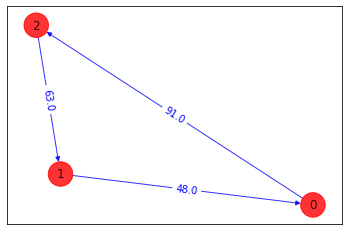

In [54]:
draw_tsp_solution(tsp.graph, order, colors, pos)